# 所得分布：発展会計と成長会計

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pwtdata   # Penn World Table Dataset

## データ

この章では，経済の所得水準を一人当たりGDPとして捉え、世界経済での所得分布や経済成長率の分布に関連する問題を考える。データは[Penn World Talbe 10.0](https://www.rug.nl/ggdc/productivity/pwt/?lang=en)を使うが，ここではデータをインポートするために`pwtdata`モジュールを使う。

````{note}
次のコマンドで`pwtdata`モジュールをインストールできる。
```
pip install git+https://github.com/spring-haru/pwtdata.git
```
````

In [2]:
df = pwtdata.load()
# pwtdata.load(description=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12810 entries, 0 to 12809
Data columns (total 52 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   countrycode    12810 non-null  object 
 1   country        12810 non-null  object 
 2   currency_unit  12810 non-null  object 
 3   year           12810 non-null  int64  
 4   rgdpe          10399 non-null  float64
 5   rgdpo          10399 non-null  float64
 6   pop            10399 non-null  float64
 7   emp            9529 non-null   float64
 8   avh            3492 non-null   float64
 9   hc             8637 non-null   float64
 10  ccon           10399 non-null  float64
 11  cda            10399 non-null  float64
 12  cgdpe          10399 non-null  float64
 13  cgdpo          10395 non-null  float64
 14  cn             10314 non-null  float64
 15  ck             7095 non-null   float64
 16  ctfp           6412 non-null   float64
 17  cwtfp          6412 non-null   float64
 18  rgdpna

`.head()`を使って最初の5行を表示する。

In [4]:
df.head()

,countrycode,country,currency_unit,year,rgdpe,rgdpo,pop,emp,avh,hc,...,csh_x,csh_m,csh_r,pl_c,pl_i,pl_g,pl_x,pl_m,pl_n,pl_k
0,ABW,Aruba,Aruban Guilder,1950,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABW,Aruba,Aruban Guilder,1951,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABW,Aruba,Aruban Guilder,1952,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABW,Aruba,Aruban Guilder,1953,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABW,Aruba,Aruban Guilder,1954,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


全ての列名が表示できるように属性`.columns`を使ってみる

In [5]:
df.columns

Index(['countrycode', 'country', 'currency_unit', 'year', 'rgdpe', 'rgdpo',
       'pop', 'emp', 'avh', 'hc', 'ccon', 'cda', 'cgdpe', 'cgdpo', 'cn', 'ck',
       'ctfp', 'cwtfp', 'rgdpna', 'rconna', 'rdana', 'rnna', 'rkna', 'rtfpna',
       'rwtfpna', 'labsh', 'irr', 'delta', 'xr', 'pl_con', 'pl_da', 'pl_gdpo',
       'i_cig', 'i_xm', 'i_xr', 'i_outlier', 'i_irr', 'cor_exp', 'statcap',
       'csh_c', 'csh_i', 'csh_g', 'csh_x', 'csh_m', 'csh_r', 'pl_c', 'pl_i',
       'pl_g', 'pl_x', 'pl_m', 'pl_n', 'pl_k'],
      dtype='object')

メソッド`.unique()`を使って含まれる国名を確認する。

In [6]:
country_list = df.loc[:,'country'].unique()
country_list

array(['Aruba', 'Angola', 'Anguilla', 'Albania', 'United Arab Emirates',
       'Argentina', 'Armenia', 'Antigua and Barbuda', 'Australia',
       'Austria', 'Azerbaijan', 'Burundi', 'Belgium', 'Benin',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia (Plurinational State of)', 'Brazil', 'Barbados',
       'Brunei Darussalam', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile',
       'China', "Côte d'Ivoire", 'Cameroon', 'D.R. of the Congo', 'Congo',
       'Colombia', 'Comoros', 'Cabo Verde', 'Costa Rica', 'Curaçao',
       'Cayman Islands', 'Cyprus', 'Czech Republic', 'Germany',
       'Djibouti', 'Dominica', 'Denmark', 'Dominican Republic', 'Algeria',
       'Ecuador', 'Egypt', 'Spain', 'Estonia', 'Ethiopia', 'Finland',
       'Fiji', 'France', 'Gabon', 'United Kingdom', 'Georgia', 'Ghana',
       'Guinea', 'Gambia', 'Guinea-Bissau', 'Equator

メソッド`.nunique()`を使って含まれる国数を確認する。

In [7]:
df.loc[:,'country'].nunique()

183

期間を確認する。

In [8]:
year_list = df.loc[:,'year'].unique()
year_list

array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019])

ここでは次の変数を使う。
* `cgdpo`：生産面から計算したGDP（current PPPs; in mil. 2011US\$）
    * 経済間では一定な価格を使い計算されているが、時系列的には「名目」
    * ある年に経済間の比較をするのに適している
* `emp`：雇用者数（in millions）
* `ck`：資本サービス水準（current PPPs (USA=1)）
    * 資本ストックを生産に使うことにより得るサービス
* `hc`：人的資本の指標
    * 教育年数と教育の収益から計算されている

## 発展会計

### 説明

経済間の所得格差の要因を探るために，次の生産関数を考えよう。

$$
Y_i=A_iK_i^\alpha H_i^{1-\alpha}
,\quad
H_i=h_iL_i
,\quad
0<\alpha<1
$$

* $i$：経済`i`
* $Y_i$：GDP
* $K_i$：資本ストック
* $A_i$：全要素生産性（TFP）
* $H_i$：人的資本ストック
* $h_i$：労働者一人当たりの人的資本ストック
* $L_i$：労働者数

生産関数を一人当たりに書き換えよう。

$$
\frac{Y_i}{L_i}=A_i
\left(
    \frac{K_i}{L_i}
\right)^{\alpha}h_i^{1-\alpha}
\quad\Rightarrow\quad
y_i=A_ik_i^{\alpha}h_i^{1-\alpha}
$$

* 一人当たりGDP：$y_i\equiv\dfrac{Y_i}{L_i}=$ `cgdpo`/`emp`
* 一人当たり資本：$k_i\equiv\dfrac{K_i}{L_i}=$ `ck`/`emp`
    * データには次に２つが含まれている。
        * `cn`：資本ストック（current PPPs, in mil. 2011US\$)
        * `ck`：資本サービス（current PPPs, USA=1)
    * 例としてタクシーを考えよう。
        * `cn`：タクシーの車の価格
        * `ck`：タクシーのサービス（走行距離など）
* 労働者一人当たり人的資本：$h_i=$ `hc`
* 資本の所得シャア：$\alpha=1/3$を仮定
* 蓄積生産要素の寄与：$k_i^{\alpha}h_i^{1-\alpha}$
* 全要素生産性：$A_i=\dfrac{y_i}{k_i^{\alpha}h_i^{1-\alpha}}$

上で使ったデータを使い、それぞれの変数を計算してみる。

In [9]:
# 資本の所得シャア
a=1/3.0

# 労働者一人当たりGDP
df['gdp_pc'] = df['cgdpo'] / df['emp']

# 一人当たり資本
df['k_pc'] = df['ck'] / df['emp']

# 蓄積生産要素
df['factors'] = df['k_pc']**a * df['hc']**(1-a)

# 全要素生産性
df['tfp'] = df['gdp_pc'] / df['factors']

### 2019年

2019年だけを抽出する。

In [10]:
df2019 = df.query('year == 2019').copy()

> エラーを防ぐためにメソッド`.copy()`を使い、2019だけの`DataFrame`を作成している。

全ての国の一人当たりGDPを米国の一人当たりGDPで割り、米国を１（基準）として議論を進める。

In [11]:
df2019['gdp_pc_relative'] = df2019['gdp_pc'].to_numpy() / \
    df2019.query('country == "United States"')['gdp_pc'].to_numpy()

>`.to_numpy()`は`NumPy`の`array`に変換するメソッドである。

#### 人的資本

全ての国の`hc`を米国の`hc`で割り、基準化する。

In [12]:
df2019['hc_relative'] = df2019['hc'].to_numpy() / \
    df2019.query('country == "United States"')['hc'].to_numpy()

散布図

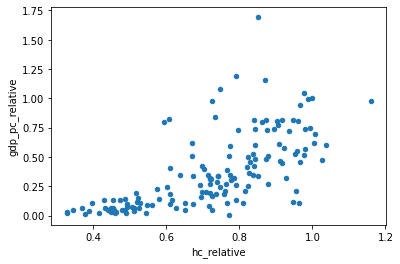

In [13]:
df2019.plot(x='hc_relative', y='gdp_pc_relative', kind='scatter')
pass

正の関係があることがわかる。

#### 物的資本

全ての国の`k_pc`を米国の`k_pc`で割り基準化する。

In [14]:
df2019['k_pc_relative'] = df2019['k_pc'].to_numpy() / \
    df2019.query('country == "United States"')['k_pc'].to_numpy()

散布図

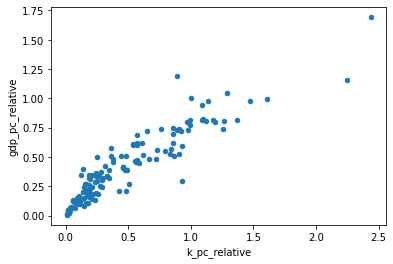

In [15]:
df2019.plot(x='k_pc_relative', y='gdp_pc_relative', kind='scatter')
pass

正の関係があり、人的資本よりも相関関係は強いことがわかる。

#### 全要素生産性

米国を`1`に基準化して一人当たりGDPと全要素生産性との関係を図示する。

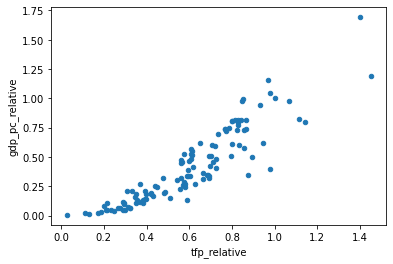

In [16]:
df2019['tfp_relative'] = df2019['tfp'].to_numpy() / \
    df2019.query('country == "United States"')['tfp'].to_numpy()

df2019.plot(x='tfp_relative', y='gdp_pc_relative', kind='scatter')
pass

この図から経済間の一人当たりGDP差は全要素生産性の差と非常に近いことがわかる。相関係数を計算してみる。

In [17]:
df2019.loc[:,['gdp_pc_relative','tfp_relative']].dropna().corr()

,gdp_pc_relative,tfp_relative
gdp_pc_relative,1.000000,0.905357
tfp_relative,0.905357,1.000000


> `.dropna()`は`NaN`がある行を削除するメソッド<br>
> `.corr()`は相関係数を計算するメソッド

`GDPpc_relative`と`tfp_relative`の相関係数は約`0.93`であり、非常に高いことがわかる。

次に2019年のデータを使い、一人当たりGDPと生産要素の寄与との関係を図示する。

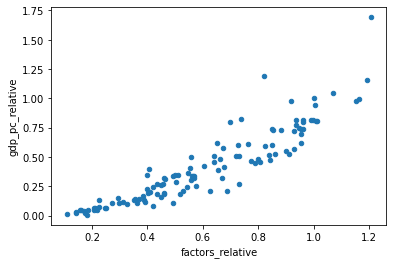

In [18]:
df2019['factors_relative'] = df2019['factors'].to_numpy() / \
    df2019.query('country == "United States"')['factors'].to_numpy()

df2019.plot(x='factors_relative', y='gdp_pc_relative', kind='scatter')
pass

相関係数を計算しよう。

In [19]:
df2019.loc[:,['gdp_pc_relative','factors_relative']].dropna().corr()

,gdp_pc_relative,factors_relative
gdp_pc_relative,1.000000,0.911408
factors_relative,0.911408,1.000000


相関係数は全要素生産性と大きく変わらない。

### 全要素生産性と蓄積生産要素の寄与度

全要素生産性と蓄積生産要素はそれぞれ一人当たりGDPの差にどれだけ寄与しているかを考えるための１つの方法として次の式が提唱されている。まず生産関数を使い以下を定義する。

$$
R_i^y=R_i^{\text{tfp}}R_i^{\text{factors}}
$$

$$
R_i^y\equiv\dfrac{y_i}{y_{\text{US}}},\quad
R_i^{\text{tfp}}\equiv\dfrac{A_i}{A_{\text{US}}},\quad
R_i^{\text{factors}}\equiv\dfrac{k_i^ah_i^{1-a}}{k_{\text{US}}^ah_{\text{US}}^{1-a}}
$$

1. $R_i^y$：米国を基準とした相対所得
1. $R_i^{\text{tfp}}$：米国を基準とした相対全要素生産性
1. $R_i^{\text{factors}}$：米国を基準とした相対生産要素

両辺に対数を取り、相対所得$R_i$の分散を計算する。

$$
\text{Var}\left(\log\left(R_i^y\right)\right) =
\text{Var}\left(\log\left(R_i^{\text{tfp}}\right)\right) +
\text{Var}\left(\log\left(R_i^{\text{factors}}\right)\right) +
2\text{Cov}\left(\log\left(R_i^{\text{tfp}}\right),\log\left(R_i^{\text{factors}}\right)\right)
$$

左辺の相対所得の変動は右辺の３つの項に分解することができる。
1. 相対全要素生産性の変動：$\text{Var}\left(\log\left(R_i^{\text{tfp}}\right)\right)$
1. 相対生産要素の変動：$\text{Var}\left(\log\left(R_i^{\text{factors}}\right)\right)$
1. 相対全要素生産性と相対生産要素の共分散散：$2\text{Cov}\left(\log\left(R_i^{\text{tfp}}\right),\log\left(R_i^{\text{factors}}\right)\right)$

これを利用して

$$
\begin{align*}
\text{全要素生産性の寄与度}&=
\dfrac{
    \text{Var}\left(\log\left(R_i^{\text{tfp}}\right)\right)
    +\text{Cov}\left(\log\left(R_i^{\text{tfp}}\right),\log\left(R_i^{\text{factors}}\right)\right)
    }{
    \text{Var}(\log(R_i^y))
    } \\
\text{蓄積生産要素の寄与度}&=
\dfrac{
    \text{Var}\left(\log\left(R_i^{\text{factors}}\right)\right)
    +\text{Cov}\left(\log\left(R_i^{\text{tfp}}\right),\log\left(R_i^{\text{factors}}\right)\right)
    }{
    \text{Var}(\log(R_i^y))
    }    
\end{align*}
$$

を定義する。ここで $2\text{Cov}\left(\log\left(R_i^{\text{tfp}}\right),\log\left(R_i^{\text{factors}}\right)\right)$ は等分されている。


（考え方）

極端な例として、全ての経済の全要素生産性が同じで蓄積生産要素だけが異なる場合を考えよう。即ち，

$$
\text{Var}\left(\log\left(R_i^{\text{tfp}}\right)\right)
=\text{Cov}\left(\log\left(R_i^{\text{tfp}}\right),\log\left(R_i^{\text{factors}}\right)\right)
=0
$$

この場合、蓄積生産要素だけで一人当たりGDPの違いを説明できることになるため、全要素生産性の寄与度は`0`であり蓄積生産要素は`1`である。即ち、一人当たりGDP（対数）の分散に対して分散がより大きいほど説明力が高いといえる。

In [20]:
# 欠損値であるNaNがある行を削除
df2019_nonan = df2019.dropna(subset=['gdp_pc_relative','tfp_relative', 'factors_relative'])

# それぞれの変数（対数）を設定
tfp     = np.log(df2019_nonan['tfp_relative'])
factors = np.log(df2019_nonan['factors_relative'])
gdp_pc  = np.log(df2019_nonan['gdp_pc_relative'])

# 分散・共分散の計算
tfp_var         = tfp.var()
factors_var     = factors.var()
gdp_pc_var      = gdp_pc.var()
tfp_factors_cov = np.cov(tfp.values,factors.values)[0,1]

**全要素生産性の寄与度**

In [21]:
(tfp_var + tfp_factors_cov) / gdp_pc_var

0.5045124027276578

相対所得の変動の約`50`%は全要素生産性によって説明される。

**蓄積生産要素の寄与度**

In [22]:
(factors_var + tfp_factors_cov) / gdp_pc_var

0.4954875972723424

相対所得の変動の約`50`%は蓄積生産要素によって説明される。

### 表の作成

最後に、主要な国のデータを表にまとめてみる。

In [23]:
#（１）〜（４）については以下で説明する。

#（１）
country_table = ['Japan', 'United Kingdom','United States', 'Norway',
                'Mexico','Peru','India','China','Zimbabwe','Niger']

#（２）
cond = df2019['country'].isin(country_table)

#（３）
col = ['country','gdp_pc_relative','tfp_relative','factors_relative']

#（４）
table2019 = df2019.loc[cond,col].set_index('country') \
                  .sort_values('gdp_pc_relative', ascending=False) \
                  .round(2) \
                  .rename(columns={'gdp_pc_relative':'一人当たりGDP',
                                   'tfp_relative':'全要素生産性',
                                   'factors_relative':'蓄積生産要素'})

print('米国を１として')
table2019

米国を１として


,一人当たりGDP,全要素生産性,蓄積生産要素
country,,,
Norway,1.05,0.98,1.07
United States,1.00,1.00,1.00
United Kingdom,0.70,0.73,0.95
Japan,0.55,0.62,0.90
Mexico,0.33,0.59,0.57
China,0.19,0.42,0.46
Peru,0.18,0.40,0.46
India,0.14,0.40,0.35
Zimbabwe,0.05,0.21,0.22


上のコードを説明する。
* (１）：表示する国のリスト
* (２）：列`country`に`country_list`にある国名と同じであれば`True`、異なる場合は`False`を返す条件を作成している。
    * `.isin()`はそのためのメソッド
* (３）：表の列ラベルに使う変数リスト
* (３）：`DataFrame`を作成する。
    * `.loc[cond,col]`を使い、`cond`の条件に合った行、そして`col`の列を抽出する。
    * `.set_index('country')`は`country`の列を行ラベルに設定するメソッド。
    * `.sort_values()`は`DataFrame`を列`gdp_pc_relative`に従って並び替えるメソッドであり、`ascending=False`は降順を指定している。
    * `.round(2)`は表示する小数点を第二桁までで四捨五入することを指定するメソッド。
    * `.rename()`は列ラベルを変更するメソッド。
    
＜コメント＞`print()`関数を使うとテキストとして表示される。

In [24]:
print(f"日本の全要素生産性は米国の{table2019.loc['Japan','全要素生産性']*100}%であり，"
      f"蓄積生産要素は米国の{table2019.loc['Japan','蓄積生産要素']*100}%である。")

日本の全要素生産性は米国の62.0%であり，蓄積生産要素は米国の90.0%である。


## 成長会計

### 説明

発展会計では一人当たりGDPを分解し、全要素生産性と蓄積生産要素に分けてその寄与度を考えた。成長会計では、一人当たりGDPの変化率（即ち、経済成長率）を同じように２つの要素に分解しそれぞれの寄与度を考察する。$t$時点の生産関数は

$$
y_t=A_tk_t^ah_t^{1-a}
$$

であり、$t$時点と$t+1$時点の生産関数を使うと

$$
\frac{y_{t+1}}{y_t}=\frac{A_{t+1}}{A_t}\left(\frac{k_{t+1}}{k_t}\right)^a\left(\frac{h_{t+1}}{h_t}\right)^{1-a}
$$

となる。ここで

$$
1+g_x\equiv\frac{x_{t+1}}{x_t}
$$

としよう。$g_x$は$x$の成長率（例えば、0.02）である。これにより、

$$
    1+g_y=(1+g_A)(1+g_k)^a(1+g_h)^{1-a}
$$

となり、対数化すると

$$
    \log(1+g_y)=\log(1+g_A)+a\log(1+g_k)+(1-a)\log(1+g_h)
$$

となる。また成長率が十分に小さい場合（例えば、0.02）、次式で近似することが可能となる。

$$
\log(1+g_x)\approx g_x
$$

In [25]:
np.log(1+0.02)

0.01980262729617973

即ち、
$$
    g_y=g_A+ag_k+(1-a)g_h
$$

それぞれの成長率を計算するために同じデータを使うが、`cgdpo`の代わりに次の変数を使う。
* `rgdpo`：生産面から計算した実質GDP（連鎖PPPs (in mil. 2011US\$)）
    * 経済間でも時系列的にも一定な価格を使い計算されている
    * 時系列的な比較をするのに適している

使うデータの期間を$n$とし、変数$x$の$n$年間の年間平均成長率を$g_x$としよう。この場合、次式が成立する。

$$
\frac{x_{n}}{x_{0}}=(1+g_x)^{n}
$$

この式を書き直すと次式となる。
$$
g_x=
\left(
\frac{x_{n}}{x_{0}}
\right)^{\frac{1}{n}}-1
$$

Penn World Table 10.0の次の変数を使う。
* `rgdpna`：実質GDP（2011年国内価格; in mil. 2011US\$）
    * 経済成長を考える上で適している
* `emp`：雇用者数（in millions）
* `rnna`：資本ストック（2011年国内価格; in mil. 2011US\$）
* `hc`：人的資本の指標
    * 教育年数と教育の収益から計算されている

以下で計算する変数とは次のように対応している。
* 一人当たりGDP：$y_i\equiv\dfrac{Y_i}{L_i}=$ `rgdpna`/`emp`
* 一人当たり資本：$k_i\equiv\dfrac{K_i}{L_i}=$ `rnna`/`emp`
* 労働者一人当たり人的資本：$h_i=$ `hc`
* 資本の所得シャア：$\alpha=1/3$（仮定）
* 蓄積生産要素の寄与：$k_i^{\alpha}h_i^{1-\alpha}$
* 全要素生産性：$A_i=\dfrac{y_i}{k_i^{\alpha}h_i^{1-\alpha}}$

それぞれの変数を計算しよう。

In [26]:
# 資本の所得シャア
a=1/3.0

# 一人当たりGDP
df['rgdp_pc'] = df['rgdpna'] / df['emp']

# 資本割合
df['k_pc'] = df['rnna'] / df['emp']

# 蓄積生産要素
df['factors'] = df['k_pc']**a * df['hc']**(1-a)

# 全要素生産性
df['tfp'] = df['rgdp_pc'] / df['factors']

### 一人当たりGDPの平均成長率

まず2009年から2019年の10年間の`rgdp_pc`、`k_pc`、`hc`の平均成長率を計算する。次のコードを使うが`for`ループが二重（入れ子）になっている。

In [27]:
var_list = ['rgdp_pc','k_pc','hc']   # (1)

dic = {}             # (2)

for v in var_list:   # (3)
    
    g_list = []             # (4)
    
    for c in country_list:  # (5)
        start = 2009        # (6)
        end = 2019          # (7)
        n = end-start       # (8)
        
        df_start = df.query('country == @c & year == @start')  # (9)
        df_end = df.query('country == @c & year == @end')      # (10)


        g = ( df_end[v].iat[0] / df_start[v].iat[0] )**(1/n)-1  # (11)
        g_list.append(100*g)                                    # (12)
            
    dic[v] = g_list          # (13)


df_growth = pd.DataFrame({'country':country_list,               # (14)
                          'rgdp_pc':dic['rgdp_pc'],             # (15)
                          'k_pc':dic['k_pc'],                   # (16)
                          'hc':dic['hc']})                      # (17)

* (1)：成長率を計算する対象となる変数リスト
* (2)：空の辞書。次の形になるように(1)の平均成長率のリストを格納する。
    * キー：変数名（`rgdp_pc`、`k_pc`、`hc`）
    * 値：それぞれの国の成長率からなるリスト
* (3)：(1)の`var_list`に対しての`for`ループ。１回目のループでは`rdgp_pc`について計算する。
* (4)：空リスト（役割は以下で説明）
* (5)：`country_list`に対しての`for`ループ。(3)の１回目の`for`ループで変数`rdgp_pc`に対して`country_list`にある国の成長率を下に続くコードを使って計算する。
    * (6)：最初の年を指定
    * (7)：最後の年を指定
    * (8)：何年間かを計算
    * (9)：最初の年の`DataFrame`を抽出
    * (10)：最後の年の`DataFrame`を抽出
    * (11)：平均成長率を計算する。
        * `df_end[v]`と`df_start[v]`は列ラベル`v`の列を抽出しており、`Series`として返される。
        * `.iat[0]`は`Series`の`0`番目の数値を取り出すメソッド
    * (12)：計算した成長率を(4)のリストに追加する。
        * `100`をかけて％表示にする。
* (13)： (5)のループが終わると、(4)のリストを(2)の辞書に追加する
    * 辞書に追加する際に変数名`v`を指定することにより、次のペアのデータが追加される
        * キー：変数名（`rgdp_pc`、`k_pc`、`hc`）
        * 値：それぞれの国の成長率のリスト
* (3)の`for`ループの次の変数に移り、上で説明した作業が繰り返される。
* (14)：`country_list`を`DataFrame`の列に設定
* (15)〜(17)：それぞれの成長率を`DataFrame`の列に設定
    * `dic['キー']`で`dic`の`キー`にあるリストを抽出している。

In [28]:
df_growth.head()

,country,rgdp_pc,k_pc,hc
0,Aruba,0.734869,1.094933,NaN
1,Angola,-0.991189,-0.449191,0.537529
2,Anguilla,NaN,NaN,NaN
3,Albania,0.792894,0.978772,0.230371
4,United Arab Emirates,1.622983,1.674040,0.118918


欠損値が含まれているので、`NaN`がある行は全て削除する。

In [29]:
df_growth = df_growth.dropna()

残った国数を確認する。

In [30]:
len(df_growth)

144

`rgdp_pc`の成長率のヒストグラムを図示する。

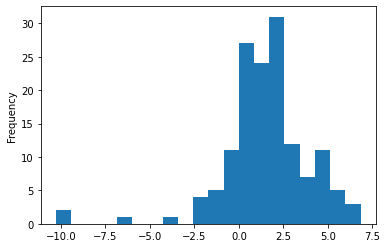

In [31]:
df_growth['rgdp_pc'].plot(kind='hist',bins=20)
pass

多くの国はプラスの経済成長を遂げているが，マイナイス成長の経済も少なからず存在する。平均成長率がマイナスの国数を計算してみよう。

In [32]:
len(df_growth.query('rgdp_pc < 0'))

24

平均成長率が約-10%の経済があるが，国名を探してみよう。

In [33]:
df_growth_sorted = df_growth.sort_values('rgdp_pc')
df_growth_sorted.head()

,country,rgdp_pc,k_pc,hc
179,Yemen,-10.259679,-0.605331,2.872344
176,Venezuela (Bolivarian Republic of),-9.486451,0.323033,1.274472
158,Syrian Arab Republic,-6.282065,1.498543,1.014550
37,Congo,-3.503272,2.635093,0.115613
94,Kuwait,-2.485174,2.457676,0.625742


ここで使ったメソッド`sort_values()`は，引数の列を基準に昇順に並べ替える。

In [34]:
print( '上のヒストグラムで`-10`付近に位置する国は'
      f'{df_growth_sorted.iloc[0,0]}と{df_growth_sorted.iloc[1,0]}である。')

上のヒストグラムで`-10`付近に位置する国はYemenとVenezuela (Bolivarian Republic of)である。


### 蓄積生産要素の成長率

蓄積生産要素の成長率を次のように定義する。

$$
g_{\text{factors}}=ag_k+(1-a)g_h
$$

計算して`df_growth`に追加してみる。その際、$a=\dfrac{1}{3}$とする。

In [35]:
df_growth['factors'] = (1/3)*df_growth['k_pc']+(1-1/3)*df_growth['hc']

`factors`の成長率のヒストグラムを図示する。

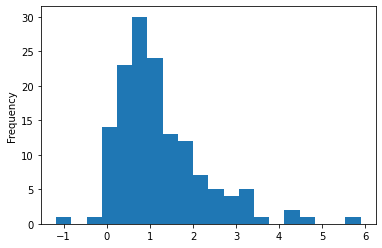

In [36]:
df_growth['factors'].plot(kind='hist',bins=20)
pass

一人当たりGDPの成長率と比べると，マイナスの成長率の国は少ないことがわかる。

### 全要素生産性

全要素生産性は残差として計算される。

$$
g_A=g_y-g_{\text{factors}}
$$

In [37]:
df_growth['tfp'] = df_growth['rgdp_pc'] - df_growth['factors']

`tfp`の成長率のヒストグラムを図示する。

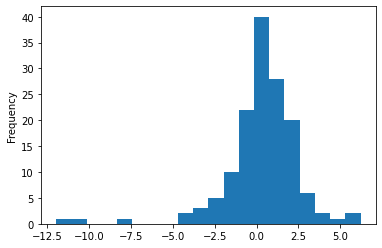

In [38]:
df_growth['tfp'].plot(kind='hist',bins=20)
pass

蓄積生産要素と比べると全要素生産性の成長率はよりマイナスに広がっている。

### 全要素生産性の貢献度

一人当たりGDPの成長率に対する全要素生産性の貢献度を数量化するが，２つの方法を考えよう。

#### 方法１

全要素生産性の貢献度を次の式で計算する。

$$
100\times\frac{g_{A}}{g_y}
$$

In [39]:
df_growth['tfp_contribution'] = 100 * df_growth['tfp']/df_growth['rgdp_pc']

全要素生産性の貢献度が`50`％以上の国は何％かを計算する。

In [40]:
tfp_contribution_more_than_50 = 100 * len(df_growth.query('50<=tfp_contribution')) / len(df_growth)

In [41]:
print(f'約{tfp_contribution_more_than_50:.1f}％の国で全要素生産性がより大きな貢献をしている。')

約50.7％の国で全要素生産性がより大きな貢献をしている。


#### 方法２

発展会計で使った方法を考える。

$$
g_{yi} = g_{Ai} + g_{\text{factors},i}
$$

従って、分散を計算すると

$$
\text{Var}\left(g_{yi}\right)=
\text{Var}\left(g_{Ai}\right)+
\text{Var}\left(g_{\text{factors},i}\right)
$$

となり、次式を定義することができる。

$$
\begin{align*}
\text{全要素生産性の寄与度}&=
\dfrac{
    \text{Var}\left(g_{Ai}\right)
    }{
    \text{Var}\left(g_{yi}\right)
    } \\
\text{生産要素の寄与度}&=
\dfrac{
    \text{Var}\left(g_{\text{factors},i}\right)
    }{
    \text{Var}\left(g_{yi}\right)
    }    
\end{align*}
$$



In [42]:
# それぞれの変数を設定
tfp_growth     = df_growth['tfp']
factors_growth = df_growth['factors']
rgdp_pc_growth = df_growth['rgdp_pc']

# 分散・共分散の計算
tfp_growth_var         = tfp_growth.var()
factors_growth_var     = factors_growth.var()
rgdp_pc_growth_var     = rgdp_pc_growth.var()

**全要素生産性の寄与度**

In [43]:
tfp_growth_var / rgdp_pc_growth_var

0.8708772738286578

**蓄積生産要素の寄与度**

In [44]:
factors_growth_var / rgdp_pc_growth_var

0.182272463465733

全要素生産性の寄与度が高いことが確認できる。

### 表の作成

In [45]:
country_table = ['Japan', 'United Kingdom','United States', 'Norway',
                'Singapore','Peru','India','China']

cond = df_growth['country'].isin(country_table)

col = ['country','rgdp_pc','factors','tfp','tfp_contribution']

df_growth.loc[cond,col].set_index('country') \
         .sort_values('rgdp_pc', ascending=False) \
         .round(2) \
         .rename(columns={'rgdp_pc':'一人当たりGDPの成長率',
                          'factors':'蓄積生産要素の成長率',
                          'tfp':'全要素生産性の成長率',
                          'tfp_contribution':'全要素生産性の寄与度(％)'})

,一人当たりGDPの成長率,蓄積生産要素の成長率,全要素生産性の成長率,全要素生産性の寄与度(％)
country,,,,
India,5.90,2.77,3.13,53.04
China,4.76,3.36,1.40,29.33
Singapore,2.46,3.30,-0.84,-34.14
Peru,2.43,1.66,0.77,31.64
United States,1.14,0.17,0.97,84.88
Japan,0.70,0.06,0.64,90.85
United Kingdom,0.61,0.21,0.41,66.08
Norway,0.40,0.61,-0.21,-53.25


### 日本

関数を使って日本の成長パフォーマンスを考える。この関数は`start`から`end`までの期間の次の変数の平均成長率と全要素生産性の寄与度をリストとして返す。

In [46]:
def jp_growth_decomposition(start, end):

    var_list = ['rgdp_pc','k_pc','hc']
    
    start = start
    end = end
    n = end-start
    
    df_start = df.query('country == "Japan" & year == @start')
    df_end = df.query('country == "Japan" & year == @end')
    
    g_list = []
    
    
    # ========== var_listの変数の平均成長率を計算しg_listに追加する ==========
    for v in var_list:
        
        g = ( df_end[v].iat[0] / df_start[v].iat[0] )**(1/n)-1
        g_list.append(100*g)

        
    # ========== 蓄積生産要素の平均成長率を計算しg_listに追加する ==========
    factors = (1/3)*g_list[1]+(1-1/3)*g_list[2]
    g_list.append(factors)

    
    # ========== 全要素生産性の平均成長率を計算しg_listに追加する ==========
    tfp = g_list[0]-factors
    g_list.append(tfp)

    # ========== 全要素生産性の寄与度を計算しg_listに追加する ==========
    tfp_contribution = 100*tfp/g_list[0]
    g_list.append(tfp_contribution)
    
    return g_list

In [47]:
# 10年ごとの平均成長率からなる辞書
dic = {'1950s':jp_growth_decomposition(1950,1959),
       '1960s':jp_growth_decomposition(1960,1969),
       '1970s':jp_growth_decomposition(1970,1979),
       '1980s':jp_growth_decomposition(1980,1989),
       '1990s':jp_growth_decomposition(1990,1999),
       '2000s':jp_growth_decomposition(2000,2010),
       '2010s':jp_growth_decomposition(2010,2019)}

# 下のDataFrameで使うインデックス
idx = ['gdp_pc_growth','k_pc_growth','hc_growth',
       'factors_growth','tfp_growth','tfp_contribution']

df_jp = pd.DataFrame(dic, index=idx)
df_jp

,1950s,1960s,1970s,1980s,1990s,2000s,2010s
gdp_pc_growth,5.818810,8.574257,3.828061,3.638507,0.905053,0.622765,0.308059
k_pc_growth,3.332503,10.090416,7.889281,3.718257,2.679254,0.502367,-0.471598
hc_growth,1.265048,0.807691,0.711507,0.560457,0.516702,0.443183,0.303400
factors_growth,1.954199,3.901933,3.104098,1.613057,1.237552,0.462911,0.045067
tfp_growth,3.864610,4.672324,0.723963,2.025450,-0.332500,0.159854,0.262992
tfp_contribution,66.415824,54.492467,18.911993,55.667066,-36.738169,25.668408,85.370519


列と行を入れ替える方が図示しやすいため、メソッド`.transpose()`を使う。

In [48]:
df_jp = df_jp.transpose()
df_jp

,gdp_pc_growth,k_pc_growth,hc_growth,factors_growth,tfp_growth,tfp_contribution
1950s,5.818810,3.332503,1.265048,1.954199,3.864610,66.415824
1960s,8.574257,10.090416,0.807691,3.901933,4.672324,54.492467
1970s,3.828061,7.889281,0.711507,3.104098,0.723963,18.911993
1980s,3.638507,3.718257,0.560457,1.613057,2.025450,55.667066
1990s,0.905053,2.679254,0.516702,1.237552,-0.332500,-36.738169
2000s,0.622765,0.502367,0.443183,0.462911,0.159854,25.668408
2010s,0.308059,-0.471598,0.303400,0.045067,0.262992,85.370519


`df_jp`を利用して棒グラフについて説明する。作成方法は図に使う変数を選択し`plot()`の引数`kind='bar'`を設定するだけである。

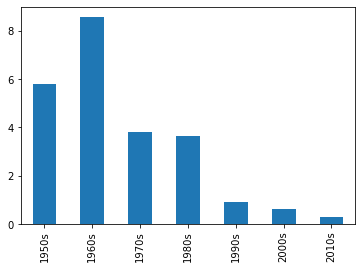

In [49]:
df_jp['gdp_pc_growth'].plot(kind='bar')
pass

1960年代をピークに成長率は下降線をたどっている。

次にヒストグラムに異なる変数を並べて表示してみよう。この場合は、表示したい変数を先に選日，`kind='bar'`を指定するだけである。

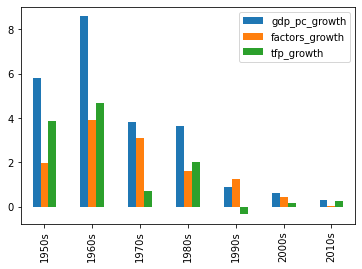

In [50]:
df_jp.iloc[:,[0,3,4]].plot(kind='bar')
pass

`stacked=True`を設定すると棒グラフを積み重ねて表示することができる。

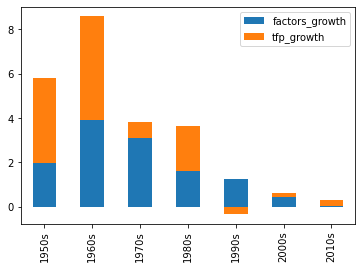

In [51]:
df_jp.iloc[:,[3,4]].plot(kind='bar', stacked=True)
pass

次のグラフでは線グラフと一緒に表示している。

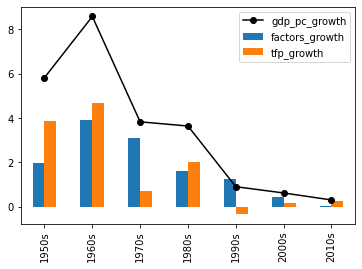

In [52]:
ax_ = df_jp.iloc[:,0].plot(marker='o',color='k',legend=True)
df_jp.iloc[:,[3,4]].plot(kind='bar',legend=True, ax=ax_)
pass

1990年代に全要素生産性の成長の大きな下落によって、寄与度はマイナスに転じている。「失われた10年」の原因と主張する研究者もいる。

## 所得分布の推移

世界経済の所得分布が時間と共にどのように変化したかを考える。手法としては，一人当たりGDPの分布自体の変化を図示して確認する。分析に使うデータはPenn World Talbe 10.0の次の２変数：
* `rgdpe`：支出面から計算したGDP（連鎖PPPs; in mil. 2011US\$）
    * 経済間そして時系列的にも一定な価格を使い計算されてい「実質」
    * 経済間そして時間の次元での比較に適している
* `pop`：人口（in millions）

一人当たりGDPの変数を作成する。

In [53]:
df['gdp_pc_log'] = np.log( df['rgdpe'] / df['pop'] )

日本の一人当たりGDP

In [54]:
y_jp = df.query('country == "Japan" & year == 2017')['gdp_pc_log']
y_jp

6157    10.577484
Name: gdp_pc_log, dtype: float64

このコードで返されるのは`Series`なので，`gdp_pc_log`の値自体を抽出するためには`.iloc[]`を使う。

In [55]:
y_jp.iloc[0]

10.57748400677992

次に2019年のヒストグラムを作成しよう。方法は簡単で，使用する列を選んでメソッド`plot()`の引数を`kind='hist'`とするだけである。

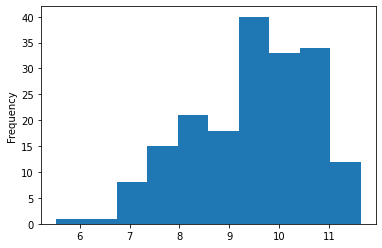

In [56]:
df.query('year == 2019')['gdp_pc_log'].plot(kind='hist')
pass

カーネル密度推定とは，上のようなヒストグラムのデータに基づき面積が１になるように分布のスムーズな形を推計する手法である。下のコードではヒストグラムとカーネル密度関数を重ねてプロットする。

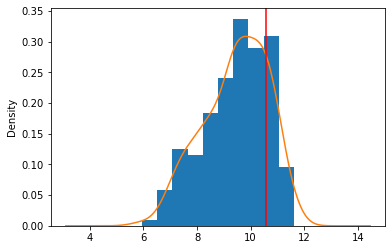

In [57]:
# ヒストグラム
ax_ = df.query('year == 2017')['gdp_pc_log'].plot(kind='hist', density=True)

# 密度関数
df.query('year == 2017')['gdp_pc_log'].plot(kind='density',ax=ax_)

# 日本
ax_.axvline(y_jp.iloc[0],color='red')
pass

>＜コードの説明＞
>* `density=True`は縦軸を確率として表示する引数
>* `kind='density'`は分布のスムーズな形を推定し表示する引数（密度関数を推定する）
>* `axvline()`は`ax_`のメソッドであり，横軸の第一引数の値に垂直線を表示する。`color`は色を指定する引数。

最頻値（モード）は中心より右側にあるが，横軸は対数になっていることを思い出そう。対数を取らない分布では，最頻値は分布の左側に位置することになる。試してみよう。

ここで確かめたいのは，70年の間に上の所得分布のどのように変化してきたか，という問題である。この問いに答えるために，カーネル密度関数（`kind=density`）を使って1950年から10年毎の分布を表示する。

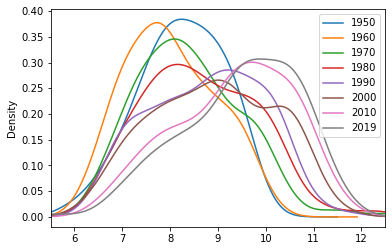

In [58]:
yr_list = list(range(1960,2020,10))+[2019]                        # (1)

_ax = df.query('year == 1950')['gdp_pc_log'].plot(kind='density', # (2)
                                                  label='1950',
                                                  legend=True)

for y in yr_list:                                                 # (3)
    df.query('year == @y')['gdp_pc_log'].plot(kind='density',     # (4)
                                              label=str(y),
                                              legend=True,
                                              ax=_ax)

_ax.set_xlim([5.5,12.5])                                          # (5)
pass

> ＜コードの説明＞
>* (1) `range(start, end, step)`は`start`から`end`までの整数を`step`の間隔準備する。更に`list()`を使ってリストに変換し，`+[2017]`を使ってリストの最後に`2017`を追加している。
>* (2) 1950年の密度関数を表示し，その「軸」を`_ax`に割り当てる。
>* (3) `yr_list`に対しての`for`ループで1960から10年毎のループとなる。
>* (4) `for`ループの中で表示する密度関数
    * 「軸」を選ぶ引数`ax`には`_ax`を選んでいる。
>* (5) `_ax`のメソッドである`set_xlim()`は横軸の表示範囲を指定する。
    * 最小値，最大値をリストもしくはタプルで指定する。
    * `set_xlim()`が設定されない場合は，自動で設定される。

分布の偏り（もしくは頂点）が左から右に移っているように見える。一方，1960年の分布の最頻値（モード）は1950年のそれの左に位置している。これは，それぞれの年に`gdp_pc`が`NaN`ではない国数は変わっており，1950年と1960年のサンプルにある国数は大きく違うためである。それぞれの年の国数を調べるために，次のコードを実行してみよう。

In [59]:
df.query('year == 2019')['gdp_pc_log'].notna().sum()

183

>＜コードの説明＞
>* `notna()`は要素が`NaN`かどうかを調べるメソッドである。要素が`NaN`であれば`False`を，`NaN`でなければ`True`を返す。
>* `True`は`1`と数えられるので，メソッド`sum()`を使うことにより`True`の数，即ち，`NaN`ではない要素の数を返す。

`for`ループを使って数えてみよう。

In [60]:
print('gdp_pc_logに含まれる国数：\n----------------------')

for y in [1950]+yr_list:
    
    no = df.query('year == @y')['gdp_pc_log'].notna().sum()

    print(f'{y}：{no}')

gdp_pc_logに含まれる国数：
----------------------
1950：55
1960：111
1970：157
1980：157
1990：181
2000：181
2010：183
2019：183


データが整備されている国は典型的に先進国であり，後から含まれる国は貧しい経済である。従って，貧しい国が所得分布に含まれることにより，分布は左側に引っ張られる傾向にある。特に，1950年から1960年には2倍以上になっており，上で説明したように，その影響で1960年の最頻値（モード）は1950年のそれよりも低くなっている。1960年以降も国数は増え続けるが，それでも分布の最頻値が右に移って行くということは，貧しい国が豊かな国に少しずつ追いついていることを示している。例えば，台湾，シンガポール，香港，韓国，中国やインドなど。

次に，分布の広がりの指標として変動係数を考えてみる。

変動係数（Coefficient of Variation）＝$\dfrac{\text{標準偏差}}{\text{平均}}$

変動係数は，平均値１単位あたりの標準偏差を表しており，平均値を使って標準化することにより分布の幅の程度を比べることが可能となる。

In [61]:
cv_list = []   # 空のリスト

for y in year_list:
    stdev = df.query('year == @y')['gdp_pc_log'].std()  # 標準偏差の計算
    avr = df.query('year == @y')['gdp_pc_log'].mean()   # 平均の計算
    cv = stdev / avr                                    # 変動係数の計算
    cv_list.append(cv)                                  # リストに追加

# インデックスに year_list を追加することによりプロットすると自動的に横軸が年になる
df_cv = pd.DataFrame({'CV':cv_list}, index=year_list)

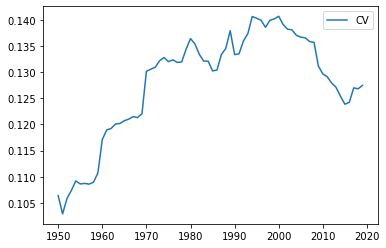

In [62]:
df_cv.plot()
pass

サンプルに含まれる国数が徐々に増えており，その影響により変動係数は増える傾向にある。1990年ごろには国数の増加は少なくり，それと同時に変動係数は減少し始めている。即ち，少なくとも1990年頃から経済間の所得格差は減少している。

＜これまでの分析で注意する点＞
* 分析の対象は国であり，それぞれの国の一人当たりGDPのみを考えた。
* **国内**の所得不平等は全く考慮されていない。
* 年によって計算に含まれる国数が異なる。